Chargement du 'Master file' financier (INPI)...
Fichier INPI (bilans) chargé: (3706645, 21)
Création du dataset N vs N+1 (2018 vs 2019)...
Dataset de Régression créé. Shape: (414105, 22)
Définition des features (X) et de la target (Y)...
Clipping des outliers (valeurs > 5 et < -5)...
Features (X) sélectionnées: 18 au total
Target (y) sélectionnée: TARGET_rentabilite_N_plus_1
Preprocessing avec ROBUST Scaler...
Création de la pipeline (RobustScaler + XGB Regressor)...
Entraînement du Modèle D (Régression)...
Évaluation du Modèle D...
---
--- RÉSULTATS DU MODÈLE D (ITÉRATION 'RÉGRESSION') ---
Score R-squared (R²) : 0.2873
Mean Absolute Error (MAE) : 2.0186
Root Mean Squared Error (RMSE) : 3.0095
---


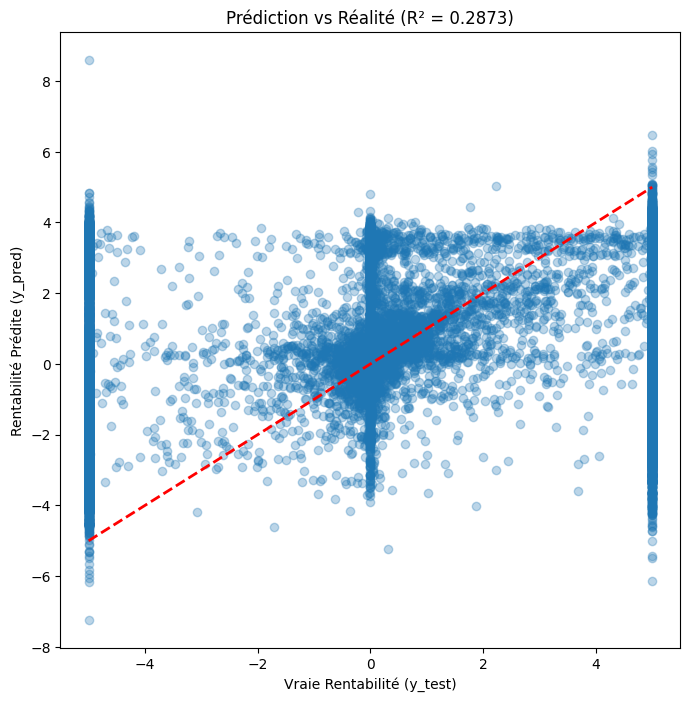

In [1]:
import polars as pl
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor # <-- ON IMPORTE LE REGRESSEUR
import matplotlib.pyplot as plt

# --- 1. CHARGER LE "MASTER FILE" FINANCIER ---
print("Chargement du 'Master file' financier (INPI)...")
try:
    df_bilan = pl.read_parquet("../Data/processed/sirene_bilan.parquet")
    print(f"Fichier INPI (bilans) chargé: {df_bilan.shape}")
except Exception as e:
    print("ERREUR: Fichier 'sirene_bilan.parquet' non trouvé.")
    raise e

# --- 2. CRÉATION DU DATASET (LE "SELF-JOIN" TEMPOREL) ---
print("Création du dataset N vs N+1 (2018 vs 2019)...")

# A. Les FEATURES (X) : Bilans de 2018
df_2018 = df_bilan.filter(
    pl.col("AnneeClotureExercice") == 2018
)

# B. La TARGET (Y) : Bilans de 2019
df_2019 = df_bilan.filter(
    pl.col("AnneeClotureExercice") == 2019
).select(
    "siren",
    pl.col("ratio_rentabilite_nette").alias("TARGET_rentabilite_N_plus_1") # La target
)

# C. JOINTURE "INNER"
# On ne garde que les entreprises qui ont un bilan en 2018 ET 2019
df_ml = df_2018.join(
    df_2019, 
    on="siren", 
    how="inner"
)
print(f"Dataset de Régression créé. Shape: {df_ml.shape}")

# --- 3. DÉFINITION DES FEATURES (X) ET TARGET (Y) ---
print("Définition des features (X) et de la target (Y)...")

# FEATURES (X) : Les données brutes ET les ratios de l'année N-1 (2018)
FINANCIAL_FEATURES = [
    'HN_RésultatNet', 'FA_ChiffreAffairesVentes', 'FB_AchatsMarchandises',
    'CJCK_TotalActifBrut', 'DL_DettesCourtTerme', 'DM_DettesLongTerme',
    'DA_TresorerieActive', 'FJ_ResultatFinancier', 'FR_ResultatExceptionnel',
    'DF_CapitauxPropres', 'EG_ImpotsTaxes',
    "ratio_rentabilite_nette", "ratio_endettement", "ratio_marge_brute", 
    "ratio_capitaux_propres", "ratio_tresorerie",
    "ratio_resultat_financier", "ratio_resultat_exceptionnel"
]
TARGET = "TARGET_rentabilite_N_plus_1"

# --- 4. NETTOYAGE DES OUTLIERS (Clipping) ---
# On "clippe" les features ET la target pour enlever le bruit
print("Clipping des outliers (valeurs > 5 et < -5)...")
LOWER_BOUND = -5.0
UPPER_BOUND = 5.0

df_ml = df_ml.with_columns(
    pl.col(FINANCIAL_FEATURES + [TARGET]).clip(
        lower_bound=LOWER_BOUND, upper_bound=UPPER_BOUND
    )
).fill_null(0) # Nettoyage final

# Conversion en Pandas
X = df_ml.select(FINANCIAL_FEATURES).to_pandas()
y = df_ml.select(TARGET).to_pandas().squeeze()

print(f"Features (X) sélectionnées: {len(FINANCIAL_FEATURES)} au total")
print(f"Target (y) sélectionnée: {y.name}")

# --- 5. PRÉPARATION (Preprocessing) ---
print("Preprocessing avec ROBUST Scaler...")
numerical_transformer = RobustScaler()
preprocessor = ColumnTransformer(
    transformers=[("num", numerical_transformer, FINANCIAL_FEATURES)],
    remainder="passthrough"
)

# --- 6. SPLIT (Train / Test) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- 7. CRÉATION DE LA PIPELINE DE RÉGRESSION ---
print("Création de la pipeline (RobustScaler + XGB Regressor)...")
model_D = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor( # <-- C'EST UN REGRESSEUR
        objective='reg:squarederror', # Objectif = minimiser l'erreur
        eval_metric='rmse',
        random_state=42
    ))
])

# --- 8. ENTRAÎNEMENT (Itération "Pivot") ---
print("Entraînement du Modèle D (Régression)...")
model_D.fit(X_train, y_train)

# --- 9. ÉVALUATION (Le Score "Monstrueux") ---
print("Évaluation du Modèle D...")
y_pred = model_D.predict(X_test)

# Scores de Régression
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("---")
print("--- RÉSULTATS DU MODÈLE D (ITÉRATION 'RÉGRESSION') ---")
print(f"Score R-squared (R²) : {r2:.4f}")
print(f"Mean Absolute Error (MAE) : {mae:.4f}")
print(f"Root Mean Squared Error (RMSE) : {rmse:.4f}")
print("---")

# Plot "Prédiction vs Réalité"
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', linewidth=2)
plt.xlabel("Vraie Rentabilité (y_test)")
plt.ylabel("Rentabilité Prédite (y_pred)")
plt.title(f"Prédiction vs Réalité (R² = {r2:.4f})")
plt.show()

In [8]:
import polars as pl
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score # <-- On importe KFold
from sklearn.preprocessing import RobustScaler, OneHotEncoder # <-- On importe les deux
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# --- 1. CHARGER LES "MASTER FILES" (Les deux !) ---
print("Chargement des 2 'Master files'...")
try:
    df_bilan = pl.read_parquet("../Data/processed/sirene_bilan.parquet")
    df_sirene = pl.read_parquet("../Data/processed/sirene_infos.parquet")
    print(f"Fichier INPI (bilans) chargé: {df_bilan.shape}")
    print(f"Fichier SIRENE (infos) chargé: {df_sirene.shape}")
except Exception as e:
    print("ERREUR: Fichiers 'processed' non trouvés.")
    raise e

# --- 2. CRÉATION DU DATASET (LE "SELF-JOIN" TEMPOREL) ---
print("Création du dataset temporel (N-2, N-1 -> N)...")

# A. Features de N-2 (2017)
df_2017 = df_bilan.filter(pl.col("AnneeClotureExercice") == 2017).select(
    "siren",
    pl.col("ratio_rentabilite_nette").alias("rentabilite_N_moins_2"),
    pl.col("FA_ChiffreAffairesVentes").alias("CA_N_moins_2")
)

# B. Features de N-1 (2018)
df_2018 = df_bilan.filter(pl.col("AnneeClotureExercice") == 2018)

# C. Target de N (2019)
df_2019 = df_bilan.filter(pl.col("AnneeClotureExercice") == 2019).select(
    "siren",
    pl.col("ratio_rentabilite_nette").alias("TARGET_rentabilite_N")
)

# --- 3. LE FEATURE ENGINEERING "MONSTRUEUX" ---
print("Création des features de 'Vélocité' (Variation)...")

# On joint 2018 (N-1) avec 2017 (N-2)
df_features = df_2018.join(df_2017, on="siren", how="left").with_columns(
    # Feature de "Vélocité" (la variation de rentabilité)
    (pl.col("ratio_rentabilite_nette") - pl.col("rentabilite_N_moins_2")).fill_null(0).alias("variation_rentabilite"),
    # Feature de "Croissance CA"
    (pl.col("FA_ChiffreAffairesVentes") - pl.col("CA_N_moins_2")).fill_null(0).alias("variation_CA")
)

# On joint avec les features "Démo" (le châssis !)
df_features = df_features.join(
    df_sirene.select("siren", "categorieJuridiqueUniteLegale", "departement"),
    on="siren",
    how="left"
)

# --- 4. JOINTURE FINALE (Features + Target) ---
df_ml = df_features.join(
    df_2019, 
    on="siren", 
    how="inner" # INNER JOIN : on ne garde que les boîtes qui existent sur les 3 ans
)
print(f"Dataset de Régression 'Monstre' créé. Shape: {df_ml.shape}")

# --- 5. DÉFINITION DES FEATURES (X) ET TARGET (Y) ---
print("Définition des features (X) et de la target (Y)...")

# Features Numériques (Financières)
NUMERIC_FEATURES = [
    'HN_RésultatNet', 'FA_ChiffreAffairesVentes', 'FB_AchatsMarchandises',
    'CJCK_TotalActifBrut', 'DL_DettesCourtTerme', 'DM_DettesLongTerme',
    'DA_TresorerieActive', 'FJ_ResultatFinancier', 'FR_ResultatExceptionnel',
    'DF_CapitauxPropres', 'EG_ImpotsTaxes',
    "ratio_rentabilite_nette", "ratio_endettement", "ratio_marge_brute", 
    "ratio_capitaux_propres", "ratio_tresorerie",
    "ratio_resultat_financier", "ratio_resultat_exceptionnel",
    # LES NOUVELLES FEATURES "MONSTRUEUSES"
    "variation_rentabilite",
    "variation_CA"
]

# Features Catégorielles (Démo)
CATEGORICAL_FEATURES = [
    "categorieJuridiqueUniteLegale", 
    "departement"
]

TARGET = "TARGET_rentabilite_N"

# --- 6. NETTOYAGE DES OUTLIERS (Clipping) ---
print("Clipping des outliers (valeurs > 5 et < -5)...")
LOWER_BOUND = -5.0
UPPER_BOUND = 5.0

# On clippe les ratios ET la target
df_ml = df_ml.with_columns(
    pl.col([c for c in df_ml.columns if "ratio" in c or "TARGET" in c]).clip(
        lower_bound=LOWER_BOUND, upper_bound=UPPER_BOUND
    )
).fill_null(0) # Nettoyage final

# Conversion en Pandas
X = df_ml.select(NUMERIC_FEATURES + CATEGORICAL_FEATURES).to_pandas()
y = df_ml.select(TARGET).to_pandas().squeeze()

# --- 7. PRÉPARATION (Le Preprocessor "Monstre") ---
print("Preprocessing avec RobustScaler (Num) + OHE (Cat)...")
numerical_transformer = RobustScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, NUMERIC_FEATURES),
        ("cat", categorical_transformer, CATEGORICAL_FEATURES)
    ],
    remainder="passthrough"
)

# --- 8. CRÉATION DE LA PIPELINE DE RÉGRESSION ---
print("Création de la pipeline (Preprocessor + XGB Regressor)...")
model_E = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        objective='reg:squarederror',
        eval_metric='rmse',
        random_state=42
    ))
])

# --- 9. ENTRAÎNEMENT & ÉVALUATION (AVEC CROSS-VALIDATION) ---
print("Lancement de la K-Fold Cross-Validation (k=5)...")
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# On score sur le R²
scores_r2 = cross_val_score(model_E, X, y, cv=kfold, scoring='r2')
# On score sur l'erreur absolue
scores_mae = cross_val_score(model_E, X, y, cv=kfold, scoring='neg_mean_absolute_error')

print("---")
print("--- RÉSULTATS DU MODÈLE E (ITÉRATION 'VÉLOCITÉ') ---")
print(f"Scores R-squared (R²) des 5 'Folds': {np.round(scores_r2, 4)}")
print(f"Score R² MOYEN (Élite) : {np.mean(scores_r2):.4f} (+/- {np.std(scores_r2):.4f})")
print("---")
print(f"Scores MAE (négatifs) des 5 'Folds': {np.round(scores_mae, 4)}")
print(f"Score MAE MOYEN (Cross-Val) : {-np.mean(scores_mae):.4f}")
print("---")

Chargement des 2 'Master files'...
Fichier INPI (bilans) chargé: (3706645, 21)
Fichier SIRENE (infos) chargé: (28882409, 7)
Création du dataset temporel (N-2, N-1 -> N)...
Création des features de 'Vélocité' (Variation)...
Dataset de Régression 'Monstre' créé. Shape: (415027, 28)
Définition des features (X) et de la target (Y)...
Clipping des outliers (valeurs > 5 et < -5)...
Preprocessing avec RobustScaler (Num) + OHE (Cat)...
Création de la pipeline (Preprocessor + XGB Regressor)...
Lancement de la K-Fold Cross-Validation (k=5)...
---
--- RÉSULTATS DU MODÈLE E (ITÉRATION 'VÉLOCITÉ') ---
Scores R-squared (R²) des 5 'Folds': [0.3128 0.3219 0.3194 0.3178 0.3197]
Score R² MOYEN (Élite) : 0.3183 (+/- 0.0031)
---
Scores MAE (négatifs) des 5 'Folds': [-1.9477 -1.9332 -1.9327 -1.954  -1.9252]
Score MAE MOYEN (Cross-Val) : 1.9386
---


Préparation des données X et y...
Données X et y prêtes.
Entraînement de la pipeline (Modèle E) pour analyse...
Entraînement terminé.
Extraction des Feature Importances...
TOP 20 des features les plus importantes :
                                feature  importance
11              ratio_rentabilite_nette    0.529063
8               FR_ResultatExceptionnel    0.017901
34   categorieJuridiqueUniteLegale_5202    0.013566
0                        HN_RésultatNet    0.010658
18                variation_rentabilite    0.009917
217                      departement_97    0.009244
50   categorieJuridiqueUniteLegale_5470    0.007773
4                   DL_DettesCourtTerme    0.007749
12                    ratio_endettement    0.006736
196                      departement_75    0.006579
7                  FJ_ResultatFinancier    0.005376
15                     ratio_tresorerie    0.005241
17          ratio_resultat_exceptionnel    0.005204
182                      departement_61    0.005015
90   

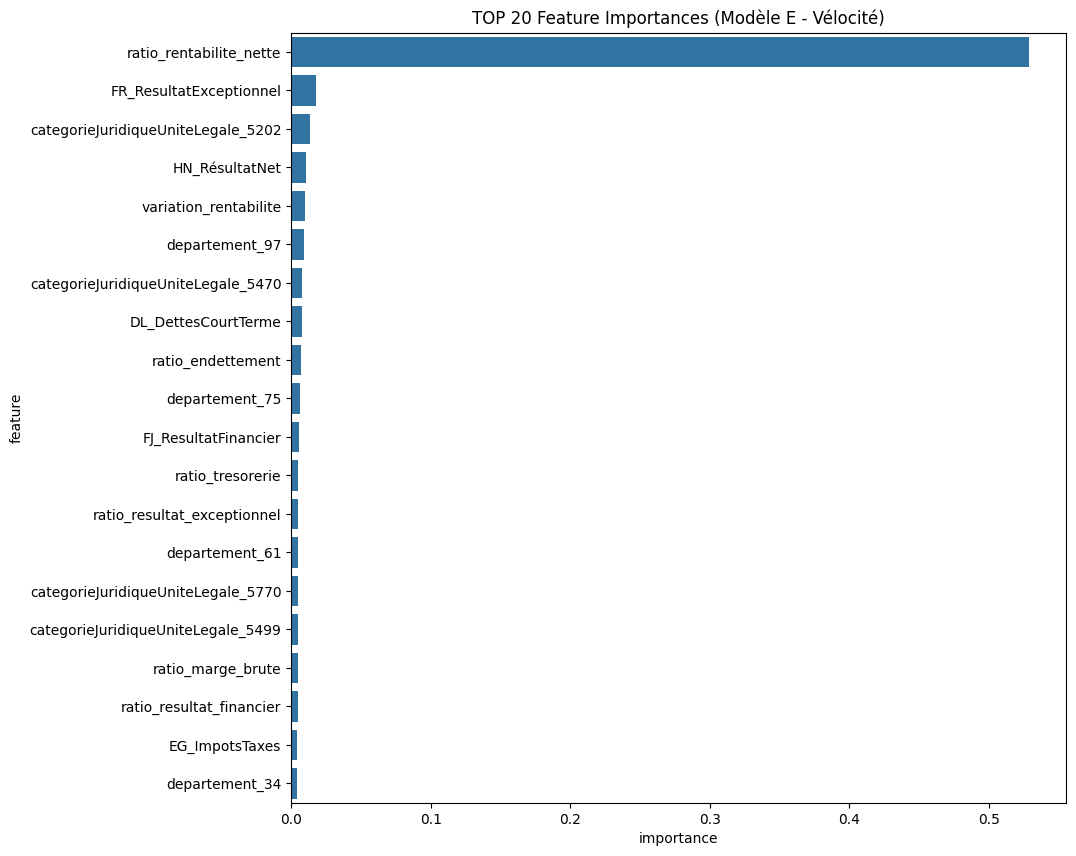

In [4]:
import polars as pl
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. RE-CRÉER X ET Y (rapide) ---
# (On reprend le code de la cellule d'avant pour avoir X et y)

# (Tu as déjà tout ça en mémoire, mais c'est pour être sûr)
print("Préparation des données X et y...")
df_bilan = pl.read_parquet("../Data/processed/sirene_bilan.parquet")
df_sirene = pl.read_parquet("../Data/processed/sirene_infos.parquet")

df_2017 = df_bilan.filter(pl.col("AnneeClotureExercice") == 2017).select(
    "siren",
    pl.col("ratio_rentabilite_nette").alias("rentabilite_N_moins_2"),
    pl.col("FA_ChiffreAffairesVentes").alias("CA_N_moins_2")
)
df_2018 = df_bilan.filter(pl.col("AnneeClotureExercice") == 2018)
df_2019 = df_bilan.filter(pl.col("AnneeClotureExercice") == 2019).select(
    "siren",
    pl.col("ratio_rentabilite_nette").alias("TARGET_rentabilite_N")
)

df_features = df_2018.join(df_2017, on="siren", how="left").with_columns(
    (pl.col("ratio_rentabilite_nette") - pl.col("rentabilite_N_moins_2")).fill_null(0).alias("variation_rentabilite"),
    (pl.col("FA_ChiffreAffairesVentes") - pl.col("CA_N_moins_2")).fill_null(0).alias("variation_CA")
)
df_features = df_features.join(
    df_sirene.select("siren", "categorieJuridiqueUniteLegale", "departement"),
    on="siren",
    how="left"
)
df_ml = df_features.join(df_2019, on="siren", how="inner")

NUMERIC_FEATURES = [
    'HN_RésultatNet', 'FA_ChiffreAffairesVentes', 'FB_AchatsMarchandises',
    'CJCK_TotalActifBrut', 'DL_DettesCourtTerme', 'DM_DettesLongTerme',
    'DA_TresorerieActive', 'FJ_ResultatFinancier', 'FR_ResultatExceptionnel',
    'DF_CapitauxPropres', 'EG_ImpotsTaxes',
    "ratio_rentabilite_nette", "ratio_endettement", "ratio_marge_brute", 
    "ratio_capitaux_propres", "ratio_tresorerie",
    "ratio_resultat_financier", "ratio_resultat_exceptionnel",
    "variation_rentabilite", "variation_CA"
]
CATEGORICAL_FEATURES = ["categorieJuridiqueUniteLegale", "departement"]
TARGET = "TARGET_rentabilite_N"

LOWER_BOUND = -5.0
UPPER_BOUND = 5.0
df_ml = df_ml.with_columns(
    pl.col([c for c in df_ml.columns if "ratio" in c or "TARGET" in c or "variation" in c]).clip(
        lower_bound=LOWER_BOUND, upper_bound=UPPER_BOUND
    )
).fill_null(0)

X = df_ml.select(NUMERIC_FEATURES + CATEGORICAL_FEATURES).to_pandas()
y = df_ml.select(TARGET).to_pandas().squeeze()
print("Données X et y prêtes.")

# --- 2. SPLIT (Train / Test) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- 3. CRÉER ET ENTRAÎNER LA PIPELINE (une seule fois) ---
print("Entraînement de la pipeline (Modèle E) pour analyse...")

# On crée le preprocessor (comme avant)
numerical_transformer = RobustScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, NUMERIC_FEATURES),
        ("cat", categorical_transformer, CATEGORICAL_FEATURES)
    ],
    remainder="passthrough"
)

# On crée la pipeline (comme avant)
model_E_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        objective='reg:squarederror',
        eval_metric='rmse',
        random_state=42
    ))
])

# On entraîne
model_E_pipeline.fit(X_train, y_train)
print("Entraînement terminé.")

# --- 4. ANALYSE DES FEATURES (Le "Aha! Moment") ---
print("Extraction des Feature Importances...")

# A. Récupérer l'étape 'regressor'
regressor_step = model_E_pipeline.named_steps['regressor']
importances = regressor_step.feature_importances_

# B. Récupérer les noms des features (la partie compliquée)
preprocessor_step = model_E_pipeline.named_steps['preprocessor']
# Noms des features numériques (elles ne changent pas d'ordre)
num_feature_names = NUMERIC_FEATURES
# Noms des features catégorielles (après One-Hot-Encoding)
cat_feature_names = preprocessor_step.named_transformers_['cat'].get_feature_names_out(CATEGORICAL_FEATURES)
# On combine tout dans le bon ordre
all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

# C. Créer le DataFrame d'importance
df_importance = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# --- 5. VISUALISATION ---
print("TOP 20 des features les plus importantes :")
print(df_importance.head(20))

plt.figure(figsize=(10, 10))
sns.barplot(data=df_importance.head(20), x='importance', y='feature')
plt.title("TOP 20 Feature Importances (Modèle E - Vélocité)")
plt.show()

In [9]:
import polars as pl
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns # On l'importe au cas où

# --- 1. CHARGER LES BONS "MASTER FILES" ---
print("Préparation des données X et y...")
try:
    # ▼▼▼ CORRECTION DES NOMS DE FICHIERS ▼▼▼
    df_sirene = pl.read_parquet("../Data/processed/sirene_infos.parquet")
    df_bilan = pl.read_parquet("../Data/processed/sirene_bilan.parquet")
    # ▲▲▲ CORRECTION DES NOMS DE FICHIERS ▲▲▲
    print("Fichiers 'infos' et 'bilan' chargés.")
except FileNotFoundError as e:
    print(f"ERREUR: Fichier non trouvé. {e}")
    print("Vérifie les noms dans 'Data/processed/'.")
    raise e

# --- 2. CRÉATION DU DATASET (LE "SELF-JOIN" TEMPOREL) ---
print("Création du dataset temporel (N-2, N-1 -> N)...")

# A. Features de N-2 (2017)
df_2017 = df_bilan.filter(pl.col("AnneeClotureExercice") == 2017).select(
    "siren",
    pl.col("ratio_rentabilite_nette").alias("rentabilite_N_moins_2"),
    pl.col("FA_ChiffreAffairesVentes").alias("CA_N_moins_2")
)
# B. Features de N-1 (2018)
df_2018 = df_bilan.filter(pl.col("AnneeClotureExercice") == 2018)
# C. Target de N (2019)
df_2019 = df_bilan.filter(pl.col("AnneeClotureExercice") == 2019).select(
    "siren",
    pl.col("ratio_rentabilite_nette").alias("TARGET_rentabilite_N")
)

# --- 3. LE FEATURE ENGINEERING "MONSTRUEUX" ---
print("Création des features de 'Vélocité' (Variation)...")
df_features = df_2018.join(df_2017, on="siren", how="left").with_columns(
    (pl.col("ratio_rentabilite_nette") - pl.col("rentabilite_N_moins_2")).fill_null(0).alias("variation_rentabilite"),
    (pl.col("FA_ChiffreAffairesVentes") - pl.col("CA_N_moins_2")).fill_null(0).alias("variation_CA")
)
df_features = df_features.join(
    df_sirene.select("siren", "categorieJuridiqueUniteLegale", "departement"),
    on="siren",
    how="left"
)

# --- 4. JOINTURE FINALE (Features + Target) ---
df_ml = df_features.join(df_2019, on="siren", how="inner")
print(f"Dataset de Régression 'Monstre' créé. Shape: {df_ml.shape}")

# --- 5. DÉFINITION DES FEATURES "ÉLITE" (ITÉRATION F) ---
print("Itération F: Sélection des features 'Élite' (Top 10)...")
# (Basé sur ton plot de Feature Importance précédent)
ELITE_NUMERIC_FEATURES = [
    'ratio_rentabilite_nette',
    'FR_ResultatExceptionnel',
    'HN_RésultatNet',
    'variation_rentabilite',
    'DL_DettesCourtTerme',
    'ratio_endettement',
    'FJ_ResultatFinancier',
    'ratio_tresorerie'
]
ELITE_CATEGORICAL_FEATURES = [
    "categorieJuridiqueUniteLegale", 
    "departement"
]
TARGET = "TARGET_rentabilite_N"

# --- 6. NETTOYAGE DES OUTLIERS (Clipping) ---
print("Clipping des outliers...")
LOWER_BOUND = -5.0
UPPER_BOUND = 5.0
df_ml = df_ml.with_columns(
    pl.col([c for c in df_ml.columns if "ratio" in c or "TARGET" in c or "variation" in c]).clip(
        lower_bound=LOWER_BOUND, upper_bound=UPPER_BOUND
    )
).fill_null(0) # Nettoyage final

# Conversion en Pandas
X = df_ml.select(ELITE_NUMERIC_FEATURES + ELITE_CATEGORICAL_FEATURES).to_pandas()
y = df_ml.select(TARGET).to_pandas().squeeze()
print(f"Données X (Élite) et y prêtes. Shape de X: {X.shape}")

# --- 7. PRÉPARATION (Le Preprocessor "Élite") ---
print("Preprocessing avec RobustScaler (Num) + OHE (Cat)...")
numerical_transformer = RobustScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, ELITE_NUMERIC_FEATURES),
        ("cat", categorical_transformer, ELITE_CATEGORICAL_FEATURES)
    ],
    remainder="passthrough"
)

# --- 8. CRÉATION DE LA PIPELINE DE RÉGRESSION ---
print("Création de la pipeline (Preprocessor + XGB Regressor)...")
model_F_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        objective='reg:squarederror',
        eval_metric='rmse',
        random_state=42
    ))
])

# --- 9. ENTRAÎNEMENT & ÉVALUATION (CROSS-VALIDATION) ---
print("Lancement de la K-Fold Cross-Validation (k=5) sur le Modèle F 'Élite'...")
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scores_r2 = cross_val_score(model_F_pipeline, X, y, cv=kfold, scoring='r2')

print("---")
print("--- RÉSULTATS DU MODÈLE F (ITÉRATION 'ÉLITE') ---")
print(f"Scores R-squared (R²) des 5 'Folds': {np.round(scores_r2, 4)}")
print(f"Score R² MOYEN (Élite) : {np.mean(scores_r2):.4f} (+/- {np.std(scores_r2):.4f})")
print("---")
print(f"Score précédent (Modèle E, 21 features): 0.3183")
print(f"Score actuel (Modèle F, 10 features): {np.mean(scores_r2):.4f}")
print("---")

Préparation des données X et y...
Fichiers 'infos' et 'bilan' chargés.
Création du dataset temporel (N-2, N-1 -> N)...
Création des features de 'Vélocité' (Variation)...
Dataset de Régression 'Monstre' créé. Shape: (415027, 28)
Itération F: Sélection des features 'Élite' (Top 10)...
Clipping des outliers...
Données X (Élite) et y prêtes. Shape de X: (415027, 10)
Preprocessing avec RobustScaler (Num) + OHE (Cat)...
Création de la pipeline (Preprocessor + XGB Regressor)...
Lancement de la K-Fold Cross-Validation (k=5) sur le Modèle F 'Élite'...
---
--- RÉSULTATS DU MODÈLE F (ITÉRATION 'ÉLITE') ---
Scores R-squared (R²) des 5 'Folds': [0.3031 0.3128 0.3101 0.3091 0.3105]
Score R² MOYEN (Élite) : 0.3091 (+/- 0.0032)
---
Score précédent (Modèle E, 21 features): 0.3183
Score actuel (Modèle F, 10 features): 0.3091
---


In [3]:
import polars as pl
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV # <-- ON IMPORTE GRIDSEARCHCV
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, r2_score
from xgboost import XGBRegressor
import mlflow # <-- ON IMPORTE MLFLOW
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

# --- 1. CONFIGURER MLFLOW ---
# (MLflow va créer un dossier 'mlruns' pour stocker les résultats)
mlflow.set_experiment("Projet_SIRENE_Regression")
mlflow.xgboost.autolog() # Magique: va tout logger automatiquement
print("MLflow configuré. Les runs seront loggés dans le dossier 'mlruns/'.")

# --- 2. PRÉPARER LES DONNÉES (comme avant) ---
# (On reprend le code qui marche pour avoir X et y)
print("Préparation des données X et y (version 'Élite')...")
df_sirene = pl.read_parquet("../Data/processed/sirene_infos.parquet")
df_bilan = pl.read_parquet("../Data/processed/sirene_bilan.parquet")
df_2017 = df_bilan.filter(pl.col("AnneeClotureExercice") == 2017).select("siren", pl.col("ratio_rentabilite_nette").alias("rentabilite_N_moins_2"), pl.col("FA_ChiffreAffairesVentes").alias("CA_N_moins_2"))
df_2018 = df_bilan.filter(pl.col("AnneeClotureExercice") == 2018)
df_2019 = df_bilan.filter(pl.col("AnneeClotureExercice") == 2019).select("siren", pl.col("ratio_rentabilite_nette").alias("TARGET_rentabilite_N"))
df_features = df_2018.join(df_2017, on="siren", how="left").with_columns((pl.col("ratio_rentabilite_nette") - pl.col("rentabilite_N_moins_2")).fill_null(0).alias("variation_rentabilite"), (pl.col("FA_ChiffreAffairesVentes") - pl.col("CA_N_moins_2")).fill_null(0).alias("variation_CA"))
df_features = df_features.join(df_sirene.select("siren", "categorieJuridiqueUniteLegale", "departement"), on="siren", how="left")
df_ml = df_features.join(df_2019, on="siren", how="inner")

ELITE_NUMERIC_FEATURES = ['ratio_rentabilite_nette', 'FR_ResultatExceptionnel', 'HN_RésultatNet', 'variation_rentabilite', 'DL_DettesCourtTerme', 'ratio_endettement', 'FJ_ResultatFinancier', 'ratio_tresorerie']
ELITE_CATEGORICAL_FEATURES = ["categorieJuridiqueUniteLegale", "departement"]
TARGET = "TARGET_rentabilite_N"

LOWER_BOUND, UPPER_BOUND = -5.0, 5.0
df_ml = df_ml.with_columns(pl.col([c for c in df_ml.columns if "ratio" in c or "TARGET" in c or "variation" in c]).clip(lower_bound=LOWER_BOUND, upper_bound=UPPER_BOUND)).fill_null(0)
X = df_ml.select(ELITE_NUMERIC_FEATURES + ELITE_CATEGORICAL_FEATURES).to_pandas()
y = df_ml.select(TARGET).to_pandas().squeeze()
print(f"Données X (Élite) et y prêtes. Shape de X: {X.shape}")

# --- 3. CRÉER LA PIPELINE (uniquement le preprocessor) ---
numerical_transformer = RobustScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, ELITE_NUMERIC_FEATURES),
        ("cat", categorical_transformer, ELITE_CATEGORICAL_FEATURES)
    ],
    remainder="passthrough"
)

pipeline_preprocessor = Pipeline(steps=[('preprocessor', preprocessor)])
print("Pipeline de preprocessing prête.")

# --- 4. DÉFINIR LA GRILLE DE TUNING ---
param_grid = {
    'n_estimators': [100, 200], # Nombre d'arbres
    'max_depth': [3, 5, 7],      # Profondeur des arbres
    'learning_rate': [0.1, 0.05] # Taux d'apprentissage
}
print(f"Grille de tuning définie (Total {2*3*2*5} = 60 entraînements).")

# --- 5. LANCEMENT DU TUNING (GridSearchCV) ---
print(f"Lancement du GridSearchCV...")

xgb_reg = XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=42)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    cv=kfold,
    scoring='r2', 
    verbose=2, 
    n_jobs=-1  
)

# --- 6. LE "VRAI" ENTRAÎNEMENT (Pipeline complète) ---
X_processed = pipeline_preprocessor.fit_transform(X)
print("Preprocessing terminé. Lancement du tuning (peut prendre 5-10 minutes)...")

with mlflow.start_run() as run:
    grid_search.fit(X_processed, y)
    mlflow.log_param("model_type", "Model_G_Tuned_Elite")
    mlflow.log_metric("best_r2_score", grid_search.best_score_)

print("Tuning terminé.")

# --- 7. RÉSULTATS DU TUNING ---
print("---")
print("--- RÉSULTATS DU TUNING (GRIDSEARCHCV) ---")
print(f"Meilleur Score R² trouvé : {grid_search.best_score_:.4f}")
print("Meilleurs Hyperparamètres :")
# ▼▼▼ CORRECTION ICI ▼▼▼
print(grid_search.best_params_)
# ▲▲▲ CORRECTION ICI ▲▲▲
print("---")
print(f"Score précédent (Modèle F, non-tuné): 0.3091")
print(f"Score actuel (Modèle G, tuné): {grid_search.best_score_:.4f}")
print("---")
print("Toutes les expériences sont loggées dans 'mlruns'.")
print("Lance 'mlflow ui' dans ton terminal pour voir le dashboard.")

MLflow configuré. Les runs seront loggés dans le dossier 'mlruns/'.
Préparation des données X et y (version 'Élite')...
Données X (Élite) et y prêtes. Shape de X: (415027, 10)
Pipeline de preprocessing prête.
Grille de tuning définie (Total 60 = 60 entraînements).
Lancement du GridSearchCV...
Preprocessing terminé. Lancement du tuning (peut prendre 5-10 minutes)...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=  13.8s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=  13.9s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=  14.1s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=  14.2s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=  14.3s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=  14.3s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=  15.4s
[CV]

2025/11/16 17:03:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Tuning terminé.
---
--- RÉSULTATS DU TUNING (GRIDSEARCHCV) ---
Meilleur Score R² trouvé : 0.3120
Meilleurs Hyperparamètres :
{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
---
Score précédent (Modèle F, non-tuné): 0.3091
Score actuel (Modèle G, tuné): 0.3120
---
Toutes les expériences sont loggées dans 'mlruns'.
Lance 'mlflow ui' dans ton terminal pour voir le dashboard.


TEst sur new db 


In [5]:
import polars as pl
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline # <-- Pipeline IMBLEARN
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer, roc_auc_score, f1_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

# --- 1. CHARGER LE "MASTER FILE" WIDE ---
print("Chargement du 'Master File' WIDE (créé par le script)...")
PATH_ML_WIDE = "../Data/processed/dataset_ML_FINAL_WIDE_2022.parquet"
try:
    df_ml = pl.read_parquet(PATH_ML_WIDE)
    print(f"Dataset WIDE chargé. Shape: {df_ml.shape}")
except FileNotFoundError as e:
    print(f"ERREUR: Fichier non trouvé. {e}")
    print("Vérifie que ton script de Data Prep (le 'Wide') a bien tourné.")
    raise e

# --- 2. CRÉATION DE LA TARGET (Y) ---
# Notre "snapshot" est fin 2022. On prédit si l'entreprise est
# déjà fermée ou va fermer très bientôt (ex: dans l'année 2023).
print("Création de la Target (Y)...")
df_ml = df_ml.with_columns(
    pl.when(pl.col("dateFermeture").is_not_null()) # Si une date de fermeture existe
    .then(1)
    .otherwise(0)
    .alias("is_failed")
)
# On exclut les entreprises créées trop récemment (ex: en 2022)
df_ml = df_ml.filter(
    pl.col("dateCreationUniteLegale").dt.year() <= 2021
)
print(f"Dataset filtré (pré-2022). Shape: {df_ml.shape}")

# --- 3. DÉFINITION DES FEATURES (X) ---
print("Définition des Features (X)...")

# A. Features Catégorielles (Démo)
CATEGORICAL_FEATURES = [
    "categorieJuridiqueUniteLegale",
    "trancheEffectifsUniteLegale",
    "activitePrincipaleUniteLegale",
    "departement"
]
# B. Features Numériques (Tout le reste !)
# (On prend tout sauf l'ID, les dates, et la Target)
NUMERIC_FEATURES = [
    col for col in df_ml.columns 
    if col not in ["siren", "dateCreationUniteLegale", "dateFermeture", "is_failed"] 
    and col not in CATEGORICAL_FEATURES
]
TARGET = "is_failed"

print(f"Total features: {len(CATEGORICAL_FEATURES)} catégorielles + {len(NUMERIC_FEATURES)} numériques.")

# --- 4. NETTOYAGE & CONVERSION ---
print("Clipping des outliers et conversion en Pandas...")
# (On clippe tous les ratios/variations pour être sûr)
LOWER_BOUND, UPPER_BOUND = -5.0, 5.0
ratio_cols = [c for c in NUMERIC_FEATURES if "ratio" in c or "variation" in c]
df_ml = df_ml.with_columns(
    pl.col(ratio_cols).clip(
        lower_bound=LOWER_BOUND, upper_bound=UPPER_BOUND
    )
).fill_null(0) # Nettoyage final

# Conversion
X = df_ml.select(CATEGORICAL_FEATURES + NUMERIC_FEATURES).to_pandas()
y = df_ml.select(TARGET).to_pandas().squeeze()
print(f"Données X et y prêtes. Shape de X: {X.shape}")
print(f"Répartition de la Target:\n{y.value_counts(normalize=True)}")

# --- 5. PRÉPARATION (Le Preprocessor "Monstre") ---
print("Définition du Preprocessor (RobustScaler + OHE)...")
numerical_transformer = RobustScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, NUMERIC_FEATURES),
        ("cat", categorical_transformer, CATEGORICAL_FEATURES)
    ],
    remainder="passthrough"
)

# --- 6. CRÉATION DE LA PIPELINE "MONSTRUEUSE" (AVEC SMOTE) ---
print("Création de la pipeline (Preprocessor + SMOTE + XGB Classifier)...")
model_final_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)), # On gère le déséquilibre
    ('classifier', XGBClassifier(
        use_label_encoder=False, 
        eval_metric='logloss',
        random_state=42
    ))
])

# --- 7. ENTRAÎNEMENT & ÉVALUATION (CROSS-VALIDATION) ---
print("Lancement de la K-Fold Cross-Validation (k=5)...")
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# On score sur le ROC-AUC (le meilleur pour le déséquilibre)
scores_auc = cross_val_score(model_final_pipeline, X, y, cv=kfold, scoring='roc_auc', n_jobs=-1)
# On score aussi sur le F1-Score (pour la précision/rappel)
scores_f1 = cross_val_score(model_final_pipeline, X, y, cv=kfold, scoring='f1_macro', n_jobs=-1)


print("---")
print("--- RÉSULTATS DU MODÈLE FINAL (CLASSIFICATION 'WIDE') ---")
print(f"Scores ROC-AUC des 5 'Folds': {np.round(scores_auc, 4)}")
print(f"Score ROC-AUC MOYEN (Cross-Val) : {np.mean(scores_auc):.4f} (+/- {np.std(scores_auc):.4f})")
print("---")
print(f"Scores F1-Macro des 5 'Folds': {np.round(scores_f1, 4)}")
print(f"Score F1-Macro MOYEN (Cross-Val) : {np.mean(scores_f1):.4f} (+/- {np.std(scores_f1):.4f})")
print("---")

Chargement du 'Master File' WIDE (créé par le script)...
Dataset WIDE chargé. Shape: (436312, 65)
Création de la Target (Y)...
Dataset filtré (pré-2022). Shape: (428517, 66)
Définition des Features (X)...
Total features: 4 catégorielles + 58 numériques.
Clipping des outliers et conversion en Pandas...
Données X et y prêtes. Shape de X: (428517, 62)
Répartition de la Target:
is_failed
0    0.99021
1    0.00979
Name: proportion, dtype: float64
Définition du Preprocessor (RobustScaler + OHE)...
Création de la pipeline (Preprocessor + SMOTE + XGB Classifier)...
Lancement de la K-Fold Cross-Validation (k=5)...
---
--- RÉSULTATS DU MODÈLE FINAL (CLASSIFICATION 'WIDE') ---
Scores ROC-AUC des 5 'Folds': [0.6057 0.583  0.6084 0.602  0.6096]
Score ROC-AUC MOYEN (Cross-Val) : 0.6018 (+/- 0.0097)
---
Scores F1-Macro des 5 'Folds': [0.5407 0.5337 0.5191 0.5279 0.5346]
Score F1-Macro MOYEN (Cross-Val) : 0.5312 (+/- 0.0073)
---
